





---


#**Загрузка данных**


---



In [1]:
# Установка необходимых библиотек
!pip install spacy nltk scikit-learn transformers datasets iterative-stratification
!python -m spacy download ru_core_news_md
!pip install evaluate
# Импорт библиотек
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import json
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 12.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Загрузка и подготовка данных
df = pd.read_csv('/content/drive/MyDrive/int/data.csv')
categories = ['Вопрос решен', 'Нравится качество выполнения заявки',
              'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок',
              'Понравилось выполнение заявки', 'Отрицательное']

# Инициализация нулями
df[categories] = 0

# Заполнение меток из строки формата JSON
def parse_sentiment(s):
    if pd.isna(s):
        return []
    try:
        sentiment_data = json.loads(s)
        if isinstance(sentiment_data, dict) and 'choices' in sentiment_data:
            return sentiment_data['choices']
        elif isinstance(sentiment_data, str):
            return [sentiment_data]
    except Exception:
        if s in categories:
            return [s]
    return []

df['parsed'] = df['sentiment'].apply(parse_sentiment)
for category in categories:
    df[category] = df['parsed'].apply(lambda x: int(category in x))

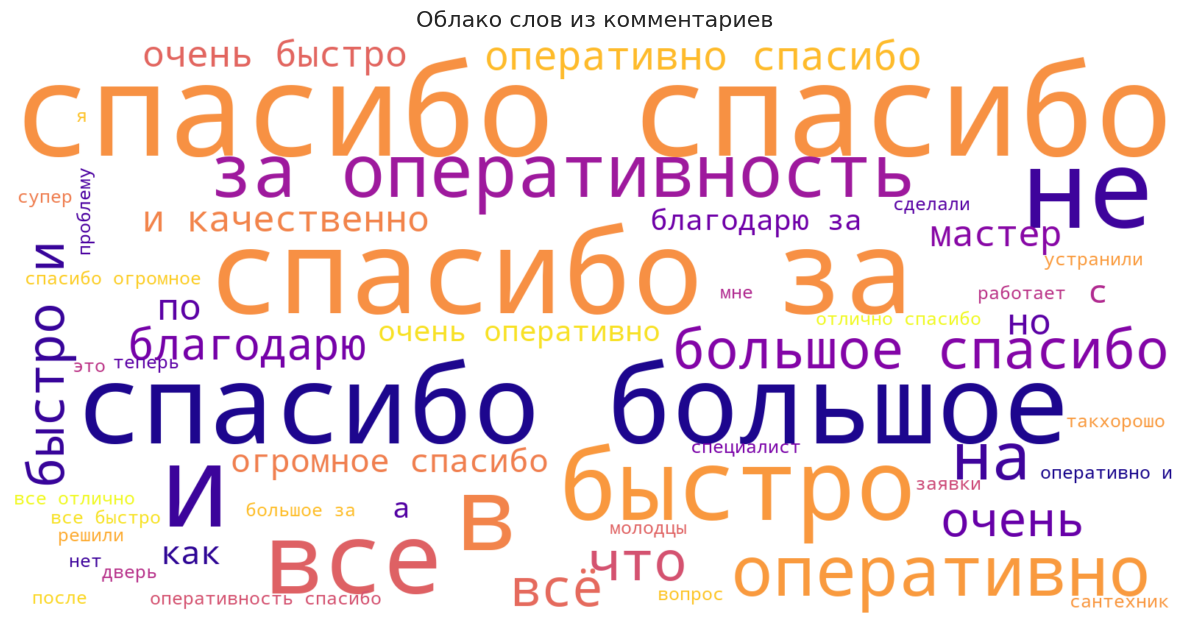

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import numpy as np

# Предобработка: удаляем пропуски
df_clean = df.dropna(subset=['comment']).copy()

# === 1. Облако слов по комментариям ===
# Загрузка маски из изображения (если оно у тебя есть)
try:
    mask = np.array(Image.open("/content/drive/MyDrive/int/1_TODO1TriwXZO-i6-Yht5zA.png"))  # исправь путь к файлу, если он другой
except FileNotFoundError:
    print("Маска не найдена, облако будет без формы")
    mask = None

# Объединение всех комментариев в одну строку
text_all = " ".join(df_clean['comment'].astype(str))

# Создание облака слов
wordcloud = WordCloud(
    width=2000,
    height=1800,
    background_color='white',
    mask=mask,
    contour_color='black' if mask is not None else None,
    contour_width=3 if mask is not None else 0,
    max_words=1500,
    colormap='plasma',
    prefer_horizontal=0.95,
    max_font_size=200,
    scale=5,
    random_state=42
).generate(text_all)

# Отображение облака слов
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.title("Облако слов из комментариев", fontsize=16)
plt.show()


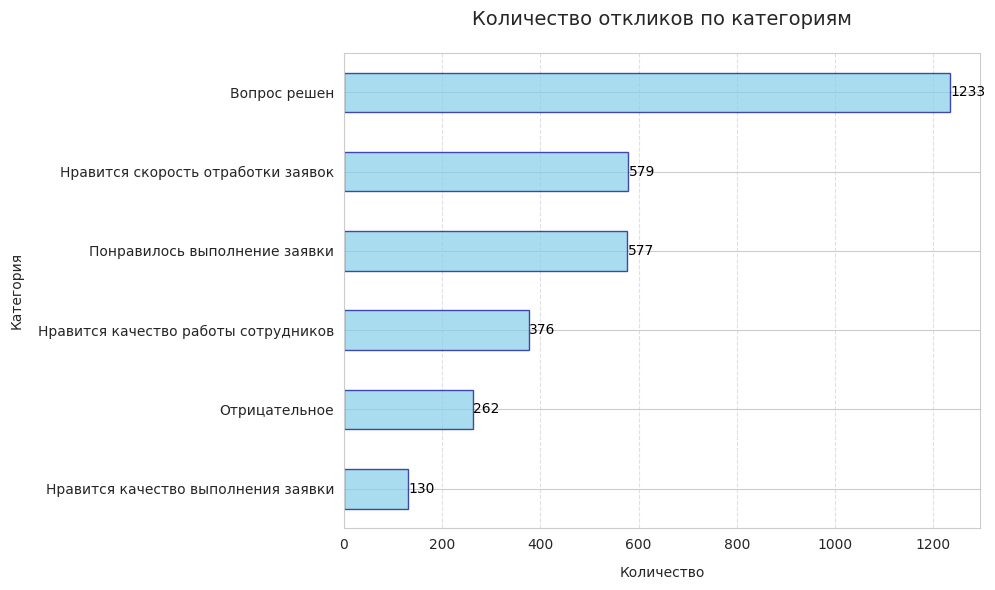

In [14]:
# === 2. Горизонтальная гистограмма откликов по категориям ===
plt.figure(figsize=(10, 6))
category_sums = df_clean[categories].sum().sort_values()
category_sums.plot(
    kind='barh',
    color='skyblue',
    edgecolor='darkblue',
    alpha=0.7
)

# Добавление подписей к столбцам
for i, v in enumerate(category_sums):
    plt.text(v + 0.5, i, str(int(v)), color='black', va='center')

# Настройка оформления графика
plt.title("Количество откликов по категориям", pad=20, fontsize=14)
plt.xlabel("Количество", labelpad=10)
plt.ylabel("Категория", labelpad=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

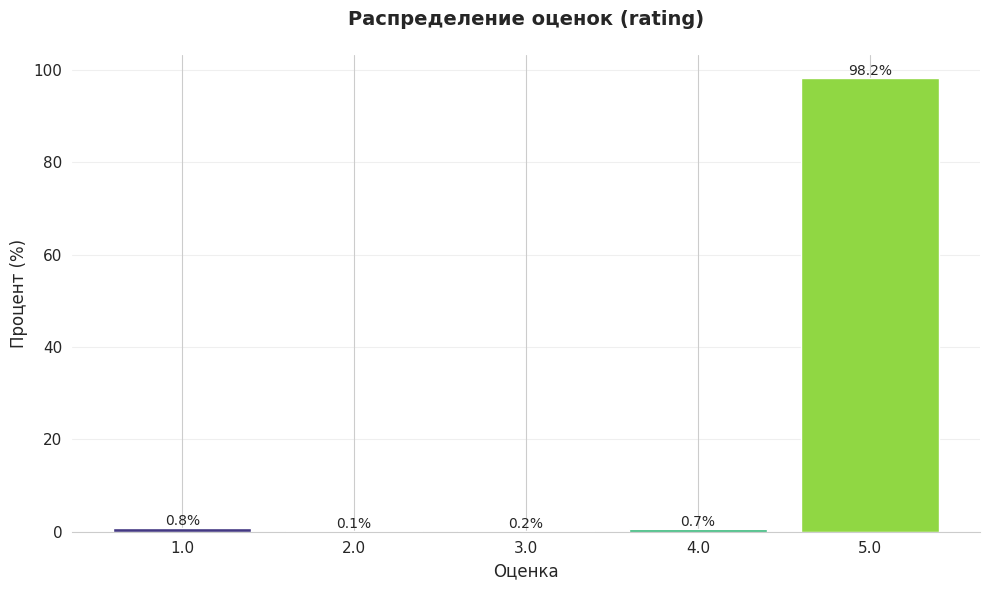

In [15]:
# === 3. Гистограмма распределения оценок (если есть столбец 'rating') ===
if 'rating' in df_clean.columns:
    rating_percent = df_clean['rating'].value_counts(normalize=True).sort_index() * 100

    # Построение гистограммы
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", len(rating_percent))
    bars = plt.bar(rating_percent.index.astype(str), rating_percent.values, color=colors)

    # Подписи на столбцах
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%',
                 ha='center', va='bottom',
                 fontsize=10)

    # Настройка графика
    plt.title("Распределение оценок (rating)\n", fontsize=14, fontweight='bold')
    plt.ylabel("Процент (%)", fontsize=12)
    plt.xlabel("Оценка", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    sns.despine(left=True)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Столбец 'rating' не найден в данных.")

---


#**Построение модели**


---


In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from collections import Counter

# Функция для ручной балансировки многометочных данных
def multilabel_oversample(X, y, max_samples=None):
    label_counts = Counter(tuple(row) for row in y.values)
    if max_samples is None:
        max_samples = max(label_counts.values())

    label_indices = {label: [] for label in label_counts}
    for idx, row in enumerate(y.values):
        label_indices[tuple(row)].append(idx)

    resampled_indices = []
    for label, indices in label_indices.items():
        n_samples = len(indices)
        if n_samples < max_samples:
            resampled_indices.extend(indices)
            resampled_indices.extend(np.random.choice(indices, size=max_samples-n_samples, replace=True))
        else:
            resampled_indices.extend(indices)

    return X.iloc[resampled_indices], y.iloc[resampled_indices]

# Разделение данных
X = df['comment']
y = df[categories]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Балансировка данных
X_res, y_res = multilabel_oversample(X_train, y_train)

# Векторизация текста
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_res)
X_test_vec = vectorizer.transform(X_test)

# Обучение модели
model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    n_jobs=-1
)
model.fit(X_train_vec, y_res)

# Предсказание и оценка
y_pred = model.predict(X_test_vec)
y_pred_proba = model.predict_proba(X_test_vec)

# Отчет по классификации
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# ROC-AUC
roc_auc_scores = []
for i, category in enumerate(categories):
    roc_auc = roc_auc_score(y_test[category], y_pred_proba[i][:, 1])
    roc_auc_scores.append(roc_auc)
    print(f"ROC-AUC for {category}: {roc_auc:.4f}")
print(f"\nAverage ROC-AUC: {np.mean(roc_auc_scores):.4f}")

Classification Report:
                                      precision    recall  f1-score   support

                        Вопрос решен       0.71      0.64      0.67       241
 Нравится качество выполнения заявки       0.25      0.15      0.19        27
Нравится качество работы сотрудников       0.84      0.52      0.64        79
  Нравится скорость отработки заявок       0.72      0.65      0.68       128
       Понравилось выполнение заявки       0.59      0.53      0.56       119
                       Отрицательное       0.76      0.89      0.82        46

                           micro avg       0.69      0.60      0.64       640
                           macro avg       0.64      0.56      0.59       640
                        weighted avg       0.69      0.60      0.64       640
                         samples avg       0.58      0.61      0.57       640

ROC-AUC for Вопрос решен: 0.7458
ROC-AUC for Нравится качество выполнения заявки: 0.6086
ROC-AUC for Нравится качест

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


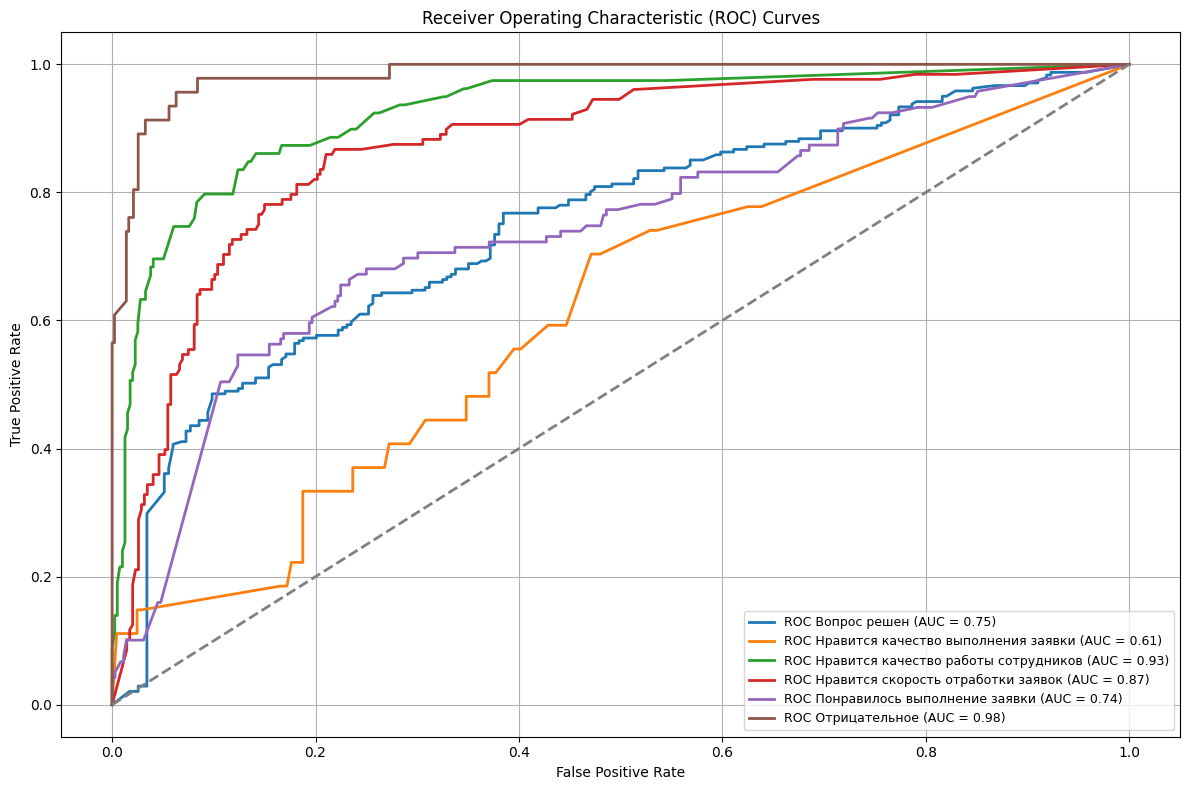

Средний ROC-AUC: 0.8126

Accuracy: 0.3958
Precision: 0.6449
Recall: 0.5625
F1 Score: 0.5935


In [4]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Подготовка ROC-кривых
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, category in enumerate(categories):
    fpr[i], tpr[i], _ = roc_curve(y_test[category], y_pred_proba[i][:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение графика ROC-кривых
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC {category} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# Средний ROC-AUC
avg_roc_auc = np.mean(list(roc_auc.values()))
print(f'Средний ROC-AUC: {avg_roc_auc:.4f}')

# Оценка метрик по бинаризованным меткам
y_true_bin = y_test.values
y_pred_bin = (np.array([proba[:, 1] for proba in y_pred_proba]).T > 0.5).astype(int)

accuracy = accuracy_score(y_true_bin, y_pred_bin)
precision = precision_score(y_true_bin, y_pred_bin, average='macro', zero_division=0)
recall = recall_score(y_true_bin, y_pred_bin, average='macro', zero_division=0)
f1 = f1_score(y_true_bin, y_pred_bin, average='macro', zero_division=0)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


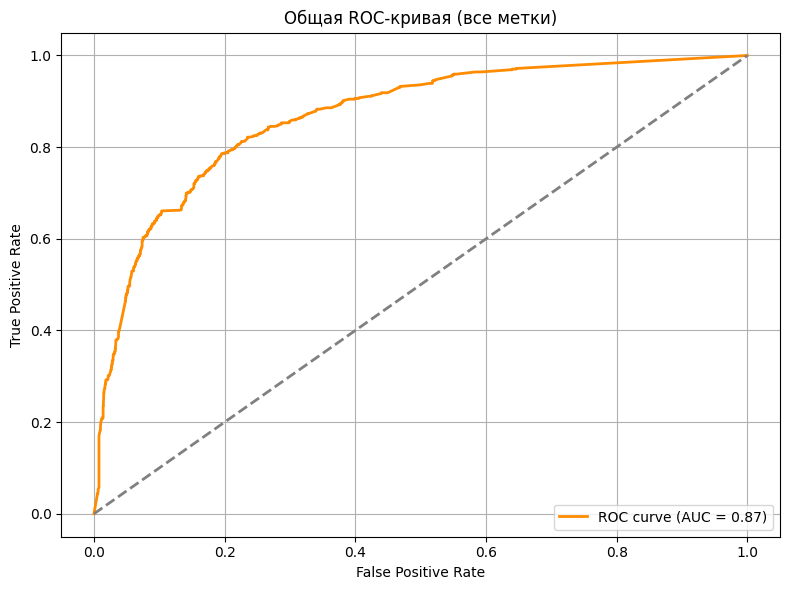


Общий ROC-AUC: 0.8666
Accuracy: 0.3958
Precision: 0.6449
Recall: 0.5625
F1 Score: 0.5935


In [5]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Преобразуем все метки и вероятности в один общий вектор
y_true_flat = y_test.values.ravel()
y_score_flat = np.array([proba[:, 1] for proba in y_pred_proba]).T.ravel()

# Построение общей ROC-кривой
fpr, tpr, _ = roc_curve(y_true_flat, y_score_flat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Общая ROC-кривая (все метки)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Метрики на основе порога 0.5
y_pred_bin = (np.array([proba[:, 1] for proba in y_pred_proba]).T > 0.5).astype(int)
y_true_bin = y_test.values

accuracy = accuracy_score(y_true_bin, y_pred_bin)
precision = precision_score(y_true_bin, y_pred_bin, average='macro', zero_division=0)
recall = recall_score(y_true_bin, y_pred_bin, average='macro', zero_division=0)
f1 = f1_score(y_true_bin, y_pred_bin, average='macro', zero_division=0)

print(f"\nОбщий ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
